In [ ]:
# import dependencies

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import  AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# import data

directory= r'/content/drive/My Drive/dataset'
categories= ['with_mask','without_mask']
print('loading images....')

loading images....


In [ ]:
with tf.device('/device:GPU:0'):

     data= []
     labels= []

     for label in categories:
         path = os.path.join(directory, label) 
         for img in os.listdir(path):
              img_path = os.path.join(path,img)
              image = load_img(img_path, target_size=(224, 224))
              image= img_to_array(image)
              #image= preprocess_input(image)
              data.append(image)
              labels.append(label)
    
          
    

    
# convert into array

data = np.array(data, dtype='float32')
labels = np.array(labels)
print('successfully loaded....')


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


successfully loaded....


In [ ]:
#convert categorical into binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size= 0.20, stratify= labels , random_state= 42 )

In [ ]:
# data augumentation for to get more data for training
aug = ImageDataGenerator( rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# first archietecture with no fully connected layer
model_1= MobileNet(weights= 'imagenet', include_top= False,
                      input_tensor=Input(shape=(224,224,3)))

In [ ]:
model_1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
# model for fully connected
model_2= model_1.output
model_2 = AveragePooling2D(pool_size=(7,7))(model_2)
model_2= Flatten(name= 'flatten')(model_2)
model_2 = Dense(128, activation='relu')(model_2)
model_2= Dropout(0.5)(model_2)
model_2 = Dense(2, activation= 'softmax')(model_2)

In [ ]:
 #Model(inputs= model_1.input, outputs= model_2)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D() )
model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model = Model(inputs= model_1.input , outputs= model_2)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [ ]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
# freezing model 1 layers for first training process
for layer in model_1.layers:
    layer.trainable = False

In [ ]:
opt = Adam(lr= INIT_LR, decay= INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
  with tf.device('/device:GPU:0'):
       print(" training head...")
       face_mask = model.fit(
	     aug.flow(trainX, trainY, batch_size=BS),
	     steps_per_epoch=len(trainX) // BS,
	     validation_data=(testX, testY),
	     validation_steps=len(testX) // BS,
	      epochs=EPOCHS)


 training head...
Epoch 1/30
76/76 [==============================] - 24s 321ms/step - loss: 0.1880 - accuracy: 0.9303 - val_loss: 0.0393 - val_accuracy: 0.9919
Epoch 2/30
76/76 [==============================] - 24s 312ms/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.0278 - val_accuracy: 0.9902
Epoch 3/30
76/76 [==============================] - 24s 315ms/step - loss: 0.0414 - accuracy: 0.9851 - val_loss: 0.0199 - val_accuracy: 0.9967
Epoch 4/30
76/76 [==============================] - 24s 317ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0204 - val_accuracy: 0.9935
Epoch 5/30
76/76 [==============================] - 24s 311ms/step - loss: 0.0179 - accuracy: 0.9967 - val_loss: 0.0204 - val_accuracy: 0.9935
Epoch 6/30
76/76 [==============================] - 24s 314ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0195 - val_accuracy: 0.9951
Epoch 7/30
76/76 [==============================] - 24s 311ms/step - loss: 0.0147 - accuracy: 0.9963 - val_loss: 0.0200 - va

In [ ]:

Ypred = model.predict(testX)


In [ ]:
Ypred = np.argmax(Ypred, axis=1)


In [ ]:
print(classification_report(testY.argmax(axis=1), Ypred,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       415
without_mask       0.99      0.99      0.99       199

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



In [ ]:
print("saving mask detector model...")
model.save("face_mask_model_data4.h5")

saving mask detector model...


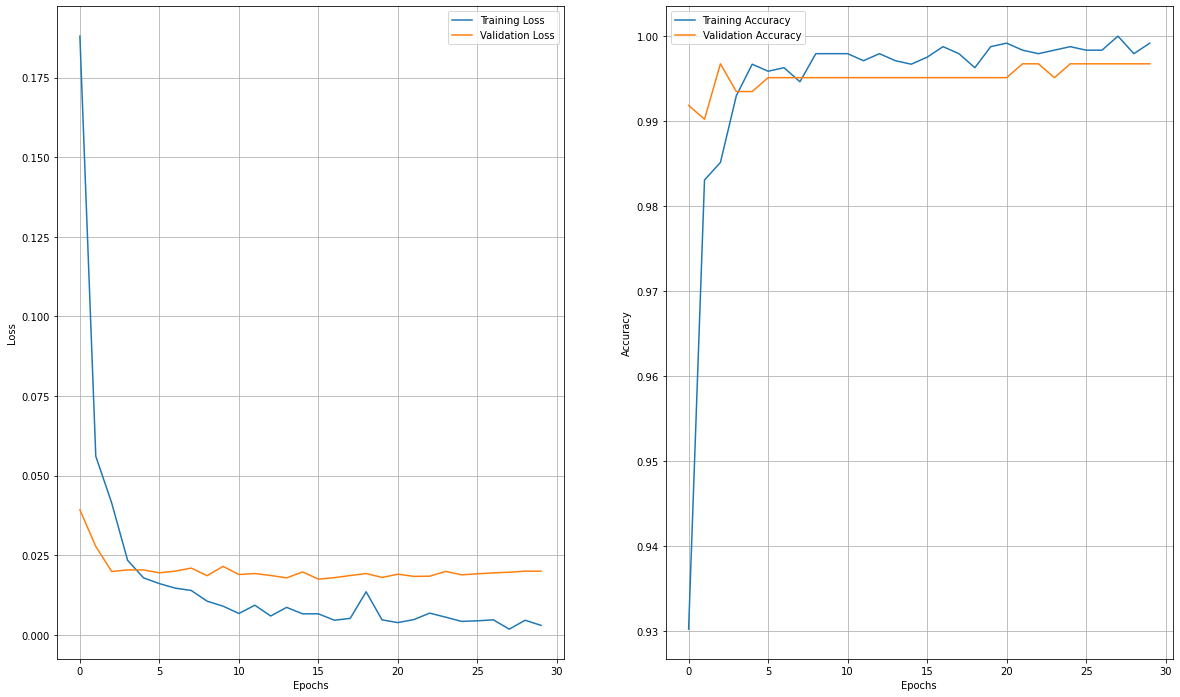

In [ ]:

X = np.arange(0,EPOCHS,1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, face_mask.history["loss"], label = "Training Loss")
plt.plot(X, face_mask.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, face_mask.history["accuracy"], label = "Training Accuracy")
plt.plot(X, face_mask.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [ ]:
keras_model = tf.keras.models.load_model(r'/content/face_mask_model_data4.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
open("face_mask2.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpk4cxpnv6/assets


13327764